In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mysql.connector
from draw_pitch import draw_pitch
import seaborn as sns
from add_features import calc_angle, calc_distance_to_goal, assist_distance
import seaborn as sns

In [2]:
# get data, decapitalize columns
sql = 'SELECT * FROM stratagem.chances WHERE icon NOT IN (\'penawarded\', \'penmissed\')'
        # WHERE type = \'open play\' AND bodypart IN (\'right\', \'left\')'

cnx = mysql.connector.connect(user='root', password='anton', host='localhost', database='stratagem')

df = pd.read_sql(sql,cnx)
cnx.close()

for col in df.columns:
    df.rename(columns={col: col.lower()}, inplace=True)

In [5]:
col_to_num = ['location_x', 'location_y', 
              'primarylocation_x', 'primarylocation_y',
              'numdefplayers', 'numattplayers', 
              'defpressure', 'shotquality']

# make numeric columns numeric, non-numeric will be NaN
for col in col_to_num:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    
# rename some columns and transpose
df.rename(columns={'location_x': 'y', 'location_y': 'x',
                   'primarylocation_x':'y2', 'primarylocation_y': 'x2',
                   'hometeam_team1': 'hometeam','awayteam_team2': 'awayteam'}, inplace=True)

In [3]:
def make_seconds(in_time):
    minute, second = in_time.split(':')
    if minute[0] == '0':
        minute == minute[1]
    return int(minute) * 60 + int(second)

df['time'] = df.apply(lambda x: make_seconds(x['time']), axis=1)

In [6]:
# convert coords to between 0 - 100
df.y = (df.y + 136)/ (1.36 * 2)
df.x = (df.x) / 4.2

df.y2 = (df.y2 + 136)/ (1.36 * 2)
df.x2 = (df.x2) / 4.2

# convert coords to meters
pitch_width = 68.0
pitch_length = 105.0
goal_size = 7.32

df['x'] = df['x'].apply(lambda x: x*pitch_length/100)
df['y'] = df['y'].apply(lambda x: x*pitch_width/100)

df['x2'] = df['x2'].apply(lambda x: x*pitch_length/100)
df['y2'] = df['y2'].apply(lambda x: x*pitch_width/100)

In [7]:
# functions imported from add_features.py
df['angle'] = df.apply(lambda x: calc_angle(x['x'], x['y']), axis=1)
df['distance'] = df.apply(lambda x: calc_distance_to_goal(x['x'], x['y']), axis=1)

# method above returns log distance + 1
df['distance'] = np.exp(df['distance']) - 1

In [8]:
def set_gamestate(gsm_id, temp_list=[]):
    
    # crete temporary df from index, sort by time
    df_temp = df[df['gsm_id'] == gsm_id][['hometeam', 'awayteam', 'team', 'time', 'icon']]    
    df_temp = df_temp.sort_values(by='time')
    # set gamestate to 0 and then to 1 for home goal, -1 for away goal
    df_temp['gamestate'] = 0
    df_temp.loc[(df_temp['icon'] == "goal") & (df_temp['team'] == df_temp["hometeam"]), 'gamestate'] = 1
    df_temp.loc[(df_temp['icon'] == "goal") & (df_temp['team'] == df_temp["awayteam"]), 'gamestate'] = -1
    # shift down so the gamestate changes for events after goal, shift creates na that is replaced w/ 0
    df_temp.gamestate = df_temp.gamestate.shift(1)
    df_temp.gamestate = df_temp.gamestate.fillna(0)
    # calculate cumulative sum in gamestate, then switch sign on away-team
    df_temp.gamestate = df_temp.gamestate.cumsum()
    df_temp.loc[df_temp['team'] == df_temp["awayteam"], 'gamestate'] = df_temp.gamestate * - 1
    # add temp_df to temp list
    temp_list.append(df_temp[['gamestate']])
    return temp_list
    
for gsm_id in df.gsm_id.unique():    
    temp_list = set_gamestate(gsm_id)
    
# concat all temp dfs and add to original df
df_temp = pd.concat(temp_list, axis=0)
df = pd.concat((df, df_temp), axis=1)

In [36]:
# number of homegoals
homegoal = df[(df['icon'] == 'goal') & (df['team'] == df['hometeam'])].groupby('competition').count()['index']
# number of awaygoals
awaygoal = df[(df['icon'] == 'goal') & (df['team'] <> df['hometeam'])].groupby('competition').count()['index']
#join together to gamecount
df_goal = pd.concat((homegoal, awaygoal, df.groupby('competition')['gsm_id'].nunique()), axis=1)
# rename columns
df_goal.columns = ['homegoals', 'awaygoals', 'gamecount']
# score rates
df_goal['hrate'] = df_goal['homegoals'] / df_goal['gamecount']
df_goal['arate'] = df_goal['awaygoals'] / df_goal['gamecount']

In [13]:
from scipy.stats import poisson
import itertools

def gravity(competition, time, gamestate, team, hometeam):
    """
    E(p|score) - E(p|miss) = gravity
    """

    # how much time left to play
    
    time_factor = (90 * 60 - time) / (90 * 60.0)
    
    # if more than 90 minutes
    if time_factor <= 0:
        time_factor = 0.0001
    
    # average goals to be scored in time left
    rate_home = df_goal.get_value(competition, 'hrate') * time_factor
    rate_away = df_goal.get_value(competition, 'arate') * time_factor
    
    # prob number of goals 
    p_home = [poisson.pmf(i, rate_home) for i in range(20)]
    p_away = [poisson.pmf(i, rate_away) for i in range(20)]
    
    home_win_miss = 0
    draw_miss = 0
    away_win_miss = 0
    
    home_win_goal = 0
    draw_goal = 0
    away_win_goal = 0
    
    # calculate xp for home and away win
    for home, away in itertools.product(enumerate(p_home), enumerate(p_away)):
        hg, ag = home[0], away[0]
        
        # add gamestate to goal
        if hometeam == team:
            hg += gamestate
        else:
            ag += gamestate
        
        prob = home[1] * away[1]
        
        # xp if miss
        if hg > ag:
            home_win_miss += prob
        elif hg < ag:
            away_win_miss += prob
        else:
            draw_miss += prob
        
        # xp if goal    
        if hometeam == team:
            hg += 1
        else:
            ag += 1
    
        if hg > ag:
            home_win_goal += prob
        elif hg < ag:
            away_win_goal += prob
        else:
            draw_goal += prob
    
    # xp for goal and miss
    if hometeam == team:
        xp_miss = 3 * home_win_miss + 1 * draw_miss
        xp_goal = 3 * home_win_goal + 1 * draw_goal
    else:
        xp_miss = 3 * away_win_miss + 1 * draw_miss
        xp_goal = 3 * away_win_goal + 1 * draw_goal
    
    # return xp for miss and goal
    return xp_goal, xp_miss

In [19]:
# function returns a tuple so split
df['gravity'] = df.apply(lambda x:
                         gravity(x['competition'], x['time'], x['gamestate'], x['team'], x['hometeam']), axis=1)
df[['xp_goal', 'xp_miss']] = df['gravity'].apply(pd.Series)

In [37]:
df = df[df['type'] == 'Open Play'] 
df = df[(df['bodypart'] == 'Right') | (df['bodypart'] == 'Left')]

In [38]:
# add defending team
df.loc[df['team'] == df['hometeam'], 'defending_team'] = df['awayteam']
df.loc[df['team'] == df['awayteam'], 'defending_team'] = df['hometeam']

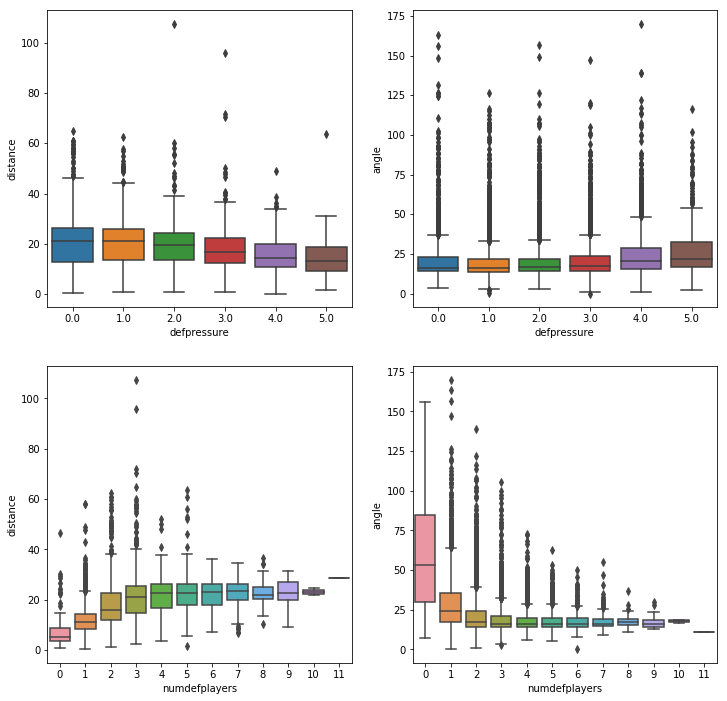

In [39]:
fig, ax = plt.subplots(2, 2, figsize=(12,12))
sns.boxplot(df.defpressure, df.angle, ax=ax[0,1])
sns.boxplot(df.defpressure, df.distance, ax=ax[0,0])
sns.boxplot(df.numdefplayers, df.angle, ax=ax[1,1])
sns.boxplot(df.numdefplayers, df.distance, ax=ax[1,0]);

In [40]:
color_leagues = {
"AusAL": "xkcd:coral" ,
"AutBL": "xkcd:green" ,
"EngCh": "xkcd:goldenrod" ,
"GerBL2": "xkcd:tomato" ,
"GreSL": "xkcd:salmon" ,
"NetED": "xkcd:lavender" ,
"NorEs": "xkcd:aqua" ,
"ScoPr": "xkcd:black" ,
"SweAV": "xkcd:lightgreen" ,
"SwiSL": "xkcd:olive" ,
"TurSL": "xkcd:tan" ,
}

# marker_leagues = {
# "AusAL": "1" ,
# "AutBL": "2" ,
# "EngCh": "3" ,
# "GerBL2": "4" ,
# "GreSL": "8" ,
# "NetED": "o" ,
# "NorEs": "x" ,
# "ScoPr": "+" ,
# "SweAV": "d" ,
# "SwiSL": "s" ,
# "TurSL": "*" ,
# }

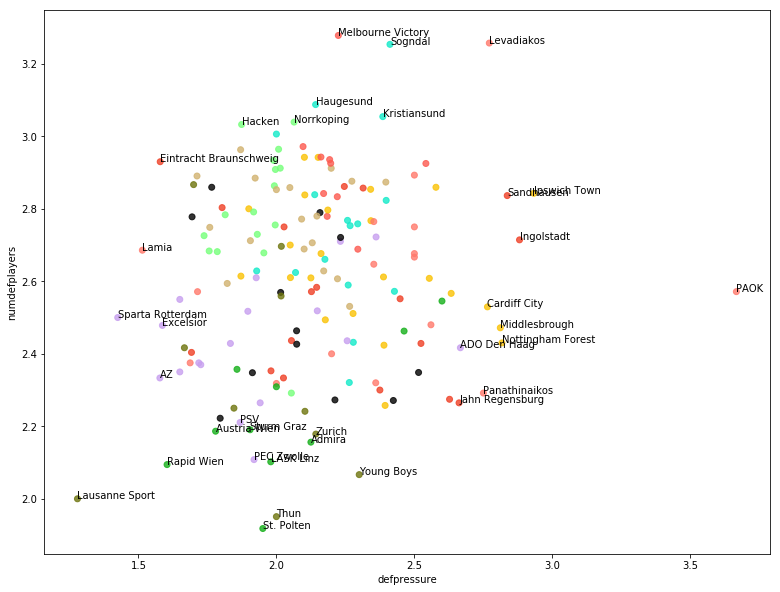

In [41]:
fig, ax = plt.subplots(figsize=(13,10))

df_test = df.groupby(['defending_team', 'competition'], as_index=False).mean()

cs = [color_leagues[x] for x in df_test.competition]

sns.regplot(df_test.defpressure, df_test.numdefplayers, ax=ax, fit_reg=False, 
            scatter_kws={'color':cs})

mean_dp = df_test.defpressure.mean()
mean_num = df_test.numdefplayers.mean()

for index, row in df_test.iterrows():
    if mean_dp  - .5 > row['defpressure'] or mean_dp + .5 < row['defpressure'] \
            or mean_num  - .4 > row['numdefplayers'] or mean_num + .4 < row['numdefplayers']:
        ax.annotate(row['defending_team'], (row['defpressure'], row['numdefplayers']))

In [42]:
# add features for defending team
#df['gamestate_defending'] = df['gamestate'] * -1
df['xp_save'] = 3 - df['xp_miss']
df['xp_concede'] = 3 - df['xp_goal']
df['concede_gravity'] = df['xp_save'] - df['xp_concede']

In [54]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

preds = ['concede_gravity', 'distance', 'angle', 'gamestate', 'time']
#preds = ['distance', 'angle', 'gamestate']

X = np.matrix(df[preds])

y_ = np.matrix(df[['defpressure', 'numdefplayers']])

x_tr, x_te, y_tr, y_te = train_test_split(X, y_, test_size=0.3, random_state=1066)

In [55]:
model = RandomForestRegressor()
#model = LinearRegression()
model.fit(x_tr, y_tr);

In [56]:
for p, c in zip(preds, model.feature_importances_):
    print p, c

concede_gravity 0.226698497152
distance 0.299806473218
angle 0.217542240044
gamestate 0.0348866137211
time 0.221066175866


In [57]:
pred_test = np.array([model.predict(x)[0] for x in x_te])

In [58]:
print "RMSE defpress:", mean_squared_error(y_te[:,0], pred_test[:,0])
print "RMSE numdef:", mean_squared_error(y_te[:,1], pred_test[:,1])

RMSE defpress: 2.08740538505
RMSE numdef: 1.5669723216


In [59]:
df_describe = pd.DataFrame()
df_describe['x_def'] = pred_test[:,0]
df_describe['defpress'] = np.squeeze(np.asarray(y_te[:,0]))

df_describe['x_num'] = pred_test[:,1]
df_describe['numdef'] = np.squeeze(np.asarray(y_te[:,1]))

df_describe.describe()

,x_def,defpress,x_num,numdef
count,5311.000000,5311.000000,5311.000000,5311.000000
mean,2.106289,2.080964,2.754943,2.713237
std,0.660852,1.366755,0.759875,1.294073
min,0.200000,0.000000,0.400000,0.000000
25%,1.700000,1.000000,2.200000,2.000000
50%,2.100000,2.000000,2.700000,3.000000
75%,2.600000,3.000000,3.300000,3.000000
max,4.200000,5.000000,6.800000,10.000000


In [113]:
pred_def = np.array([model.predict(x)[0] for x in X])
df['x_def'] = pred_def[:,0]
df['x_num'] = pred_def[:,1]

In [122]:
from sklearn.metrics import mean_squared_error
print mean_squared_error(df.defpressure, df.x_def)
print mean_squared_error(df.numdefplayers, df.x_num)

1.1637194037
0.9023225718


In [115]:
df[['x_def', 'defpressure', 'x_num', 'numdefplayers']].describe()

,x_def,defpressure,x_num,numdefplayers
count,18941.000000,18941.000000,18941.000000,18941.000000
mean,2.088919,2.092128,2.665144,2.660208
std,0.895281,1.363699,0.945368,1.307098
min,0.000000,0.000000,0.000000,0.000000
25%,1.450000,1.000000,2.000000,2.000000
50%,2.099524,2.000000,2.629762,2.000000
75%,2.700000,3.000000,3.208333,3.000000
max,5.000000,5.000000,7.828571,11.000000


In [35]:
# positive = higher press than expected
df['dev_def'] = df['defpressure'] -  df['x_def']
# positive = more defensive players than expected
df['dev_num'] =  df['numdefplayers'] - df['x_num']

KeyError: 'dev_num'

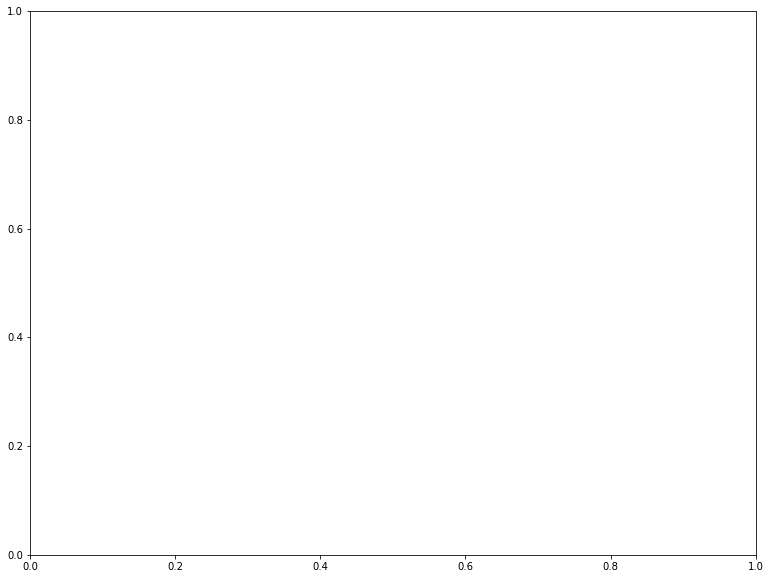

In [42]:
fig, ax = plt.subplots(figsize=(13,10))

df_def = df.groupby(by='competition', as_index=False).mean()

sns.regplot('dev_def', 'dev_num', data=df_def, fit_reg=False, ax = ax, 
            scatter_kws={'color':cs,'marker':'d', 's':100})

ax.plot((0,0),(-1,1) ,ls='--', lw=1)
ax.plot((-1,2),(0,0) ,ls='--', lw=1)

plt.xlim(-.3,.4)
plt.ylim(-.5,.2)

mean_dp_dev = df_def.dev_def.mean()
mean_num_dev = df_def.dev_num.mean()

for index, row in df_def.iterrows():
    ax.annotate(row['competition'], (row['dev_def'], row['dev_num']))

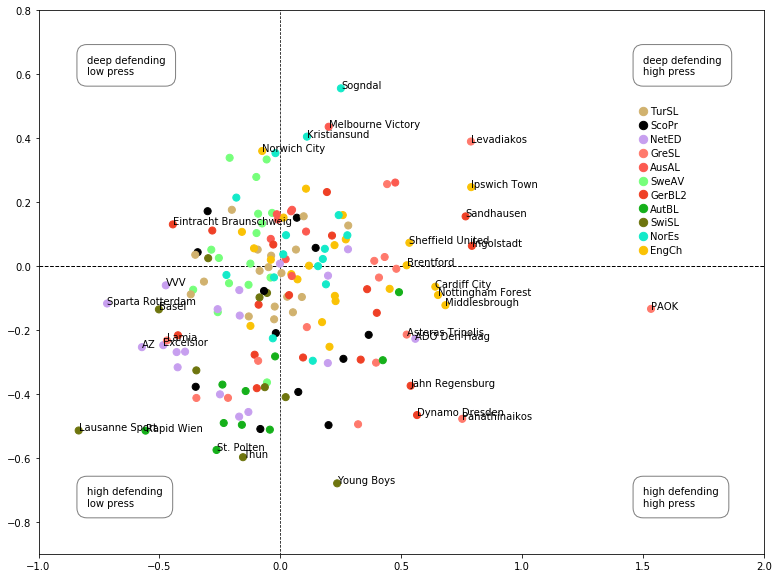

In [44]:
fig, ax = plt.subplots(figsize=(13,10))

df_def = df.groupby(by=['defending_team', 'competition'], as_index=False).mean()
#sns.regplot(df_test.defpressure, df_test.numdefplayers, fit_reg=False, ax=ax)
colors = [color_leagues[x] for x in df_def['competition']]
markers = [marker_leagues[x] for x in df_def['competition']]

ax.plot((0,0),(-1,1) ,ls='--', c='k', lw=.75, zorder=1)
ax.plot((-1,2),(0,0) ,ls='--', c='k', lw=1)

#sns.regplot('dev_def', 'dev_num', data=df_def, fit_reg=False, ax=ax, scatter_kws={'color':cs,'marker':'d'})
ax.scatter(df_def.dev_def, df_def.dev_num, c=colors, s=50, zorder=20)

#for _s, c, _x, _y in zip(markers, colors, df_def.dev_def, df_def.dev_num):
 #   ax.scatter(_x, _y, marker=_s, c=c, s=50)

plt.xlim(-1,2)
plt.ylim(-.9,.8)

mean_dp_dev = df_def.dev_def.mean()
mean_num_dev = df_def.dev_num.mean()

for index, row in df_def.iterrows():
    if mean_dp_dev  - .55 > row['dev_num'] or mean_dp_dev + .32 < row['dev_num'] \
            or mean_num_dev  - .35 > row['dev_def'] or mean_num_dev + .6 < row['dev_def']:
        ax.annotate(row['defending_team'], (row['dev_def'], row['dev_num']), zorder=21)

# legend        
for i, (comp, color) in enumerate(color_leagues.items()):
    ax.scatter(1.5, i/23.0+.05, color=color, s=70)
    ax.text(1.53, i/23.0+.04, comp)

ax.text(-.8, .6, 'deep defending\nlow press', fontsize=10, 
        bbox={'facecolor':'white', 'alpha':0.5, 'pad':1, 'boxstyle':'round'})

ax.text(1.5, .6, 'deep defending\nhigh press', fontsize=10, 
        bbox={'facecolor':'white', 'alpha':0.5, 'pad':1, 'boxstyle':'round'})

ax.text(-.8, -.75, 'high defending\nlow press', fontsize=10, 
        bbox={'facecolor':'white', 'alpha':0.5, 'pad':1, 'boxstyle':'round'})

ax.text(1.5, -.75, 'high defending\nhigh press', fontsize=10, 
        bbox={'facecolor':'white', 'alpha':0.5, 'pad':1, 'boxstyle':'round'});

In [111]:
"""
See if these teams over or underperform xG
"""

0 EngCh xkcd:goldenrod
1 NorEs xkcd:aqua
2 SwiSL xkcd:olive
3 AutBL xkcd:green
4 GerBL2 xkcd:tomato
5 SweAV xkcd:lightgreen
6 AusAL xkcd:coral
7 GreSL xkcd:salmon
8 NetED xkcd:lavender
9 ScoPr xkcd:black
10 TurSL xkcd:tan


In [19]:
#preds = [['defending_team', 'competition', 'gamestate', 'time', 'distance', 'team', 'numattplayers']]
#preds = ['gamestate', 'time', 'distance', 'angle']

#df_pred = pd.concat([df[preds], pd.get_dummies(df['competition'])], join='inner', axis=1)
#df_pred = pd.concat([df_pred, pd.get_dummies(df['defending_team'])], join='inner', axis=1)